In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Данные

In [13]:
original_data = pd.read_csv('DATA.csv')
original_data.drop('STUDENT ID', axis=1, inplace=True)

# Определяем порог успешности 
success_threshold = 4

# Добавляем новый столбец 'Success' на основании порога
original_data['Success'] = (original_data['GRADE'] >= success_threshold).astype(int)
original_data.drop('GRADE', axis=1, inplace=True)

original_data

,Student Age,Sex,Graduated high-school type,Scholarship type,Additional work,Regular artistic or sports activity,Do you have a partner,Total salary if available,Transportation to the university,Accomodation type in Cyprus,...,Preparation to midterm exams 1,Preparation to midterm exams 2,Taking notes in classes,Listening in classes,Discussion improves my interest and success in the course,Flip-classroom,Cumulative grade point average in the last semester (/4.00),Expected Cumulative grade point average in the graduation (/4.00),COURSE ID,Success
0,2,2,3,3,1,2,2,1,1,1,...,1,1,3,2,1,2,1,1,1,0
1,2,2,3,3,1,2,2,1,1,1,...,1,1,3,2,3,2,2,3,1,0
2,2,2,2,3,2,2,2,2,4,2,...,1,1,2,2,1,1,2,2,1,0
3,1,1,1,3,1,2,1,2,1,2,...,1,2,3,2,2,1,3,2,1,0
4,2,2,1,3,2,2,1,3,1,4,...,2,1,2,2,2,1,2,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,2,1,2,3,1,1,2,1,1,2,...,1,1,2,1,2,1,3,3,9,1
141,1,1,2,4,2,2,2,1,4,2,...,1,1,3,2,2,1,5,3,9,1
142,1,1,1,4,2,2,2,1,1,1,...,1,1,3,3,2,1,4,3,9,0
143,2,1,2,4,1,1,1,5,2,3,...,2,1,2,1,2,1,5,3,9,1


### Случайный отбор sqrt(n) признаков

In [14]:
count_of_columns = int(np.sqrt(len(original_data.columns)))
random_columns = original_data.sample(n=count_of_columns, axis='columns')
data = original_data[random_columns.columns].copy()
data['Success'] = original_data['Success']
data

,Number of sisters/brothers (if available),Scholarship type,Accomodation type in Cyprus,Weekly study hours,Do you have a partner,Success
0,3,3,1,3,2,0
1,2,3,1,2,2,0
2,2,3,2,2,2,0
3,5,3,2,3,1,0
4,2,3,4,2,1,0
...,...,...,...,...,...,...
140,2,3,2,3,2,1
141,5,4,2,3,2,1
142,4,4,1,2,2,0
143,1,4,3,2,1,1


#### Разделение данных на тренировочные и тестовые

In [15]:
# Выделяем целевую метку и признаки
X = data.drop(columns=['Success']).values  # Признаки (без GRADE и Success)
y = data['Success'].values  # Целевая метка успешности

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train, '\n', X_test, '\n', y_train, '\n', y_test)

[[3 3 2 2 1]
 [2 3 4 2 1]
 [4 3 1 2 1]
 [2 3 3 1 1]
 [5 5 3 3 2]
 [4 5 1 2 2]
 [2 3 3 1 2]
 [3 5 2 1 1]
 [3 3 1 1 2]
 [4 3 2 2 2]
 [2 4 2 2 2]
 [2 3 2 2 2]
 [4 4 3 2 2]
 [1 5 1 2 2]
 [3 3 1 3 2]
 [3 3 1 1 1]
 [4 3 2 2 1]
 [1 3 1 1 2]
 [5 5 1 1 2]
 [3 3 1 1 2]
 [3 3 2 2 1]
 [3 2 1 3 2]
 [2 3 1 1 1]
 [5 4 1 1 2]
 [2 3 1 2 1]
 [2 3 2 2 2]
 [3 4 3 2 1]
 [1 3 2 1 1]
 [5 3 1 4 2]
 [4 3 1 3 1]
 [2 5 1 1 2]
 [4 3 2 2 2]
 [2 4 3 2 2]
 [1 3 2 2 1]
 [5 5 2 2 1]
 [3 3 1 2 2]
 [3 5 2 2 2]
 [5 3 1 2 1]
 [3 4 1 2 1]
 [4 1 2 5 1]
 [2 3 2 3 2]
 [1 5 3 2 1]
 [2 4 2 5 2]
 [5 3 1 1 2]
 [2 3 1 1 2]
 [2 4 2 2 2]
 [1 4 3 2 1]
 [2 4 1 2 2]
 [5 4 1 2 2]
 [2 2 2 2 1]
 [3 3 1 2 1]
 [1 3 2 2 2]
 [1 3 3 1 1]
 [3 3 1 2 1]
 [1 4 1 2 1]
 [1 3 2 2 2]
 [2 3 1 1 2]
 [2 4 3 4 1]
 [1 5 2 4 2]
 [2 3 3 1 1]
 [2 5 1 1 2]
 [2 3 2 3 1]
 [2 5 1 3 1]
 [5 3 2 3 1]
 [2 3 1 2 2]
 [1 5 1 3 2]
 [2 3 2 2 1]
 [2 5 1 2 2]
 [1 4 3 2 2]
 [1 4 3 2 1]
 [2 3 2 2 2]
 [4 3 1 2 2]
 [2 3 2 2 2]
 [2 3 1 2 1]
 [4 4 1 2 2]
 [3 3 1 2 1]
 [5 4 2 3 2]

### Реализация дерева решения для классификации

+ Узел - Внутренний узел дерева, узел проверки
+ Корневой узел - начальный узел дерева решений
+ Лист - конечный узел дерева, узел решения

#### Выбор атрибута разбиения
##### Теоретико-информационный критерий
$$H=-\sum^n_{i=1}\frac{N_i}{N}\log_2{(\frac{N_i}{N})}$$
$H$ - энтропия
$n$ - число классов в исходном подмножестве
$N_i$ - число примеров $i$-го класса
$N$ - общее число примеров в подмножестве   
$$Gain(A)=Info(S)-Info(S_A)$$
$Info(S)$ - информация, связанная с подмножеством $S$ до разбиения
$Info(S_A)$ - информация, связанная с подмножеством $S$ после разбиения по атрибуту $A$.
Лучшим атрибутом разбиения $A_j$ будет тот, который обеспечит максимальный прирост информации результирующего узла относительно исходного
##### Статистический подход
$$Gini(Q)=1-\sum^n_{i=1}p^2_i$$
$Q$ - результирующее множество
$n$ - число классов в нем
$p_i$ - вероятность $i$-го класса (выраженная, как относительная частота примеров соответствующего класса)
Данный показатель меняется от 0 (если все примеры Q относятся к одному классу) до 1 (если классы представлены в равных пропорциях). Лучшим будет то разбиение, для которого значение индекса Джини будет минимальным. 
Он показывает насколько часто случайно выбранный пример обучающего множества будет распознан неправильно

In [16]:
# Класс узла дерева.
# Используется для хранения информации об узлах.
# Объект этого узла может быть либо промежуточным узлом, либо листом.
class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature      # Признак, по которому делаем разбиение
        self.threshold = threshold  # Порог для разбиения
        self.left = left            # Левое поддерево (<= порога)
        self.right = right          # Правое дерево (> порога)
        self.value = value          # Значение класса, если узел является листом
        
    def is_leaf_node(self):
        return self.value is not None
    
# Функция для вычисления индекса Джини
def gini(y):
    # counts - количество каждого уникального класса в y
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return 1 - np.sum(probabilities ** 2)


# Функция для поиска лучшего разбиения
def best_split(X, y):
    best_feature, best_threshold = None, None
    best_gini = float('inf') # максимальное возможное значение
    # кол-во строк и кол-во признаков в X 
    n_samples, n_features = X.shape 
    
    # цикл по каждому признаку X
    for feature in range(n_features):
        # для текущего признака получаем уникальные значения, как потенциальные пороги для разбиения
        thresholds = np.unique(X[:, feature])
        
        for threshold in thresholds:
            # подмножества для каждого threshold
            left_indices = X[:, feature] <= threshold 
            right_indices = X[:, feature] > threshold
            # проверяем, что и левая и правая группы содержат хотя бы один элемент
            if sum(left_indices) == 0 or sum(right_indices) == 0:
                continue
            
            # вычисляем gini для разбиения
            gini_left = gini(y[left_indices])    # индекс Джини для левой группы
            gini_right = gini(y[right_indices])  # индекс Джини для правой группы
            # взвешенный индекс Джини для текущего разбиения
            # вклад каждой группы пропорционален числу элементов в ней относительно общего числа элементов
            gini_split = (sum(left_indices) * gini_left + sum(right_indices) * gini_right) / n_samples 
            
            if gini_split < best_gini:
                best_gini = gini_split
                best_feature = feature
                best_threshold = threshold
    
    return best_feature, best_threshold
    
    
# Функция для построения дерева
# рекурсивно строит дерево решений, добавляя узлы и разбиения до достижения условий остановки
# X - данные признаков, по которым будет строиться дерево;
# y - целевые ветки для бинарной классификации;
# depth - текущая глубина узла в дереве (по умолчанию 0).
# max_depth - максимальная глубина дерева, которая ограничивает его рост(по умолчанию 10).
def build_tree(X, y, depth=0, max_depth=10):
    n_samples, n_features = X.shape
    num_classes = len(np.unique(y)) # кол-во уникальных классов в целевых значениях y
    
    # условия остановки 
    if depth >= max_depth or num_classes == 1 or n_samples < 2:
        leaf_value = np.bincount(y) / n_samples # вероятность - доля каждого класса в узле 
        leaf_value = 1 - leaf_value[0]
        return TreeNode(value=leaf_value)
        
    # выбираем лучшее разбиение, если признак не найден, узел объявляется листом с наиболее часто встречающимся классом
    feature, threshold = best_split(X, y)
    if feature is None:
        leaf_value = np.bincount(y) / n_samples
        leaf_value = 1 - leaf_value[0]
        return TreeNode(value=leaf_value)
    
    # рекурсивное разбиение данных
    left_indices = X[:, feature] <= threshold
    right_indices = X[:, feature] > threshold
    # создание поддеревьев
    left_subtree = build_tree(X[left_indices], y[left_indices], depth + 1, max_depth)
    right_subtree = build_tree(X[right_indices], y[right_indices], depth + 1, max_depth)
    # создается и возвращается узел дерева с текущим признаком, порогом и двумя дочерними поддеревьями
    return TreeNode(feature, threshold, left_subtree, right_subtree)
    

# Функция предсказания для одного образца
def predict_tree(node, x):
    if node.is_leaf_node():
        return node.value
    if x[node.feature] <= node.threshold:
        return predict_tree(node.left, x)
    else:
        return predict_tree(node.right, x)
 
 
# Основная функция предсказания
def predict(X, tree):
    return np.array([predict_tree(tree, x) for x in X])


# tree = build_tree(X_train, y_train, max_depth=20)
tree = build_tree(X, y, max_depth=20)

def print_tree(node, depth=0):
    if node.is_leaf_node():
        print("  " * depth + f"Leaf: Probability = {node.value:.2f}")
    else:
        print("  " * depth + f"Node: Feature {node.feature}, Threshold {node.threshold}")
        print("  " * depth + "Left:")
        print_tree(node.left, depth + 1)
        print("  " * depth + "Right:")
        print_tree(node.right, depth + 1)

# Выводим дерево решений
print_tree(tree)

predictions = predict(X, tree)
print(predictions)
print(y)

Node: Feature 1, Threshold 3
Left:
  Node: Feature 1, Threshold 2
  Left:
    Node: Feature 2, Threshold 1
    Left:
      Node: Feature 3, Threshold 2
      Left:
        Leaf: Probability = 1.00
      Right:
        Leaf: Probability = 0.00
    Right:
      Leaf: Probability = 1.00
  Right:
    Node: Feature 0, Threshold 4
    Left:
      Node: Feature 3, Threshold 2
      Left:
        Node: Feature 2, Threshold 1
        Left:
          Node: Feature 0, Threshold 3
          Left:
            Node: Feature 0, Threshold 2
            Left:
              Node: Feature 3, Threshold 1
              Left:
                Node: Feature 0, Threshold 1
                Left:
                  Leaf: Probability = 0.00
                Right:
                  Node: Feature 4, Threshold 1
                  Left:
                    Leaf: Probability = 1.00
                  Right:
                    Leaf: Probability = 0.50
              Right:
                Node: Feature 4, Threshold 1
   

### Оценка алгоритма
1. *Accuracy*: Доля правильных предсказаний от общего числа предсказаний.
2. *Precision*: Доля верных положительных предсказаний (True Positives) от всех положительных предсказаний (True Positives + False Positives).
3. *Reacll*: Доля верных положительных предсказаний от всех истинных положительных (True Positives + False Negatives).

In [17]:
# Подсчет True Positives, False Positives, True Negatives, False Negatives
def tp_fp_tn_fn(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred.astype(int) == 1))
    fp = np.sum((y_true == 0) & (y_pred.astype(int) == 1))
    tn = np.sum((y_true == 0) & (y_pred.astype(int) == 0))
    fn = np.sum((y_true == 1) & (y_pred.astype(int) == 0))
    print('tp:', tp)
    print('fp:', fp)
    print('tn:', tn)
    print('fn:', fn)
    return tp, fp, tn, fn
# Функция для вычисления метрик
def calculate_metrics(y_true, y_pred):
    tp, fp, tn, fn = tp_fp_tn_fn(y_true, y_pred)
    
    # Рассчет метрик
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    
    return accuracy, precision, recall

# Оценка модели
accuracy, precision, recall = calculate_metrics(y, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

tp: 34
fp: 0
tn: 88
fn: 23
Accuracy: 0.8414
Precision: 1.0000
Recall: 0.5965


### Построение кривых AUC-ROC и AUC-PR
**AUC-ROC** и **AUC-PR** - метрики для оценки качества бинарной классификационной модели

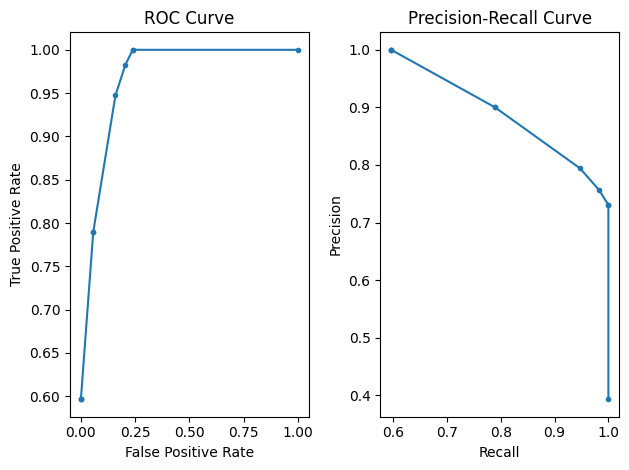

In [19]:
# Функция для вычисления TPR и FPR
def compute_roc_pr(y_true, y_scores):
    # thresholds = np.arange(0, 1.1, 0.1)
    thresholds = np.linspace(0, 1, num=10)  # Создаём 10 порогов от 0 до 1
    
    tpr_list, fpr_list, precisions, recalls = [], [], [], []
    
    for threshold in thresholds:
        # Предсказание на текущем пороге
        y_pred = (y_scores >= threshold).astype(int)
        
                # Вычисляем TP, FP, TN, FN
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        
        TPR = tp / (tp + fn) if (tp + fn) > 0 else 0
        FPR = fp / (fp + tn) if (fp + tn) > 0 else 0
        tpr_list.append(TPR)
        fpr_list.append(FPR)
        
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall = TPR
        precisions.append(precision)
        recalls.append(recall)
        
        # print(y_pred)
        # print(y_scores)
        # print(f"Threshold: {threshold}")
        # print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
        # print(f"TPR: {TPR}, FPR: {FPR}, Precision: {precision}, Recall: {recall}\n")
    
    return thresholds, fpr_list, tpr_list, precisions, recalls


y_scores = predictions  
thresholds, fpr, tpr, precisions, recalls = compute_roc_pr(y, y_scores)
# print(fpr, tpr)
# ROC-кривая
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# PR-кривая
plt.subplot(1, 2, 2)
plt.plot(recalls, precisions, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()   